## Compare results for multiple results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import subprocess as sp
import os
import glob
import sys

import itertools
import time

# from ipywidgets import *

In [2]:
%matplotlib notebook

In [3]:
# sys.path.append('/global/u1/v/vpa/project/jpt_notebooks/Cosmology/Cosmo_GAN/repositories/cosmogan_pytorch/code/modules_image_analysis/')
from modules_img_analysis import *

In [4]:
### Transformation functions for image pixel values
def f_transform(x,a):
    return 2.*x/(x + float(a)) - 1.

def f_invtransform(s,a):
    return float(a)*(1. + s)/(1. - s)


In [5]:
def f_compute_hist_spect(sample,bins):
    ''' Compute pixel intensity histograms and radial spectrum for 2D arrays
    Input : Image arrays and bins
    Output: dictionary with 5 arrays : Histogram values, errors and bin centers, Spectrum values and errors.
    '''
    ### Compute pixel histogram for row
    gen_hist,gen_err,hist_bins=f_batch_histogram(sample,bins=bins,norm=True,hist_range=None)
    ### Compute spectrum for row
    spec,spec_sdev=f_plot_spectrum_3d(sample,plot=False)

    dict1={'hist_val':gen_hist,'hist_err':gen_err,'hist_bin_centers':hist_bins,'spec_val':spec,'spec_sdev':spec_sdev }
    return dict1


def f_compute_chisqr(dict_val,dict_sample,img_size):
    '''
    Compute chi-square values for sample w.r.t input images
    Input: 2 dictionaries with 4 keys for histogram and spectrum values and errors
    '''
    ### !!Both pixel histograms MUST have same bins and normalization!
    ### Compute chi-sqr
    ### Used in keras code : np.sum(np.divide(np.power(valhist - samphist, 2.0), valhist))
    ###  chi_sqr :: sum((Obs-Val)^2/(Val))
    
    chisqr_dict={}
    
    try: 
        val_dr=dict_val['hist_val'].copy()
        val_dr[val_dr<=0.]=1.0    ### Avoiding division by zero for zero bins

        sq_diff=(dict_val['hist_val']-dict_sample['hist_val'])**2

        size=len(dict_val['hist_val'])
        l1,l2=int(size*0.3),int(size*0.7)
        keys=['chi_1a','chi_1b','chi_1c','chi_1']
        
        for (key,start,end) in zip(keys,[0,l1,l2,0],[l1,l2,None,None]):  # 4 lists : small, medium, large pixel values and full 
            chisqr_dict.update({key:np.sum(np.divide(sq_diff[start:end],val_dr[start:end]))})

        idx=None  # Choosing the number of histograms to use. Eg : -5 to skip last 5 bins
    #     chisqr_dict.update({'chi_sqr1':})

        chisqr_dict.update({'chi_2':np.sum(np.divide(sq_diff[:idx],1.0))}) ## chi-sqr without denominator division
        chisqr_dict.update({'chi_imgvar':np.sum(dict_sample['hist_err'][:idx])/np.sum(dict_val['hist_err'][:idx])}) ## measures total spread in histograms wrt to input data

        idx=img_size
        spec_diff=(dict_val['spec_val']-dict_sample['spec_val'])**2
        ### computing the spectral loss chi-square
        chisqr_dict.update({'chi_spec1':np.sum(spec_diff[:idx]/dict_sample['spec_val'][:idx]**2)})

        ### computing the spectral loss chi-square
        chisqr_dict.update({'chi_spec2':np.sum(spec_diff[:idx]/dict_sample['spec_sdev'][:idx]**2)})
        
        spec_loss=1.0*np.log(np.mean((dict_val['spec_val'][:idx]-dict_sample['spec_val'][:idx])**2))+1.0*np.log(np.mean((dict_val['spec_sdev'][:idx]-dict_sample['spec_sdev'][:idx])**2))
        chisqr_dict.update({'chi_spec3':spec_loss})
    
    except Exception as e: 
        print(e)
        
        keys=['chi_1a','chi_1b','chi_1c','chi_1','chi_2','chi_imgvar','chi_spec1','chi_spec2']
        chisqr_dict=dict.fromkeys(keys,np.nan)
        pass
    
    return chisqr_dict
    

In [6]:
img_size=64
# img_size=128

kappa=4

In [7]:
val_data_dict={'64':'/p/vast1/lbann/datasets/exagan/portal.nersc.gov/project/m3363/transfer_data_livermore/64cube_dataset/norm_1_train_val.npy',
              '128':''}


In [8]:
### Read validation data
# bins=np.concatenate([np.array([-0.5]),np.arange(0.5,20.5,1),np.arange(20.5,100.5,5),np.arange(100.5,1000.5,50),np.array([2000])]) #bin edges to use
bins=np.concatenate([np.array([-0.5]),np.arange(0.5,100.5,5),np.arange(100.5,300.5,20),np.arange(300.5,1000.5,50),np.array([2000])]) #bin edges to use
bins=f_transform(bins,kappa)   ### scale to (-1,1)

bkgnd_dict={}
num_bkgnd=100

### Extract validation data   
samples=np.load(val_data_dict[str(img_size)],mmap_mode='r')[500:600].copy()[:,0,:,:,:]
dict_val=f_compute_hist_spect(samples,bins)
del samples


In [9]:
# a1=f_invtransform(samples[0],4.0)
# np.max(a1),np.min(a1)

### Add pytorch runs

In [31]:
parent_dir='/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/'
fldr_lst=glob.glob(parent_dir+'/202306*')

print(fldr_lst)
for i in fldr_lst: 
    print(i.split('/')[-1])

run_fldr=fldr_lst[7]
print(run_fldr)


output_fldr=run_fldr+'/outputs/trainer0/model0/'
file_lst=glob.glob(output_fldr+'sgd.validation.epoch*_gen_img*.npy')
len(file_lst)

['/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230602_060059_lbann_cosmo3DGAN_n32_ppn4_failed_depth-groups', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230601_201952_lbann_cosmo3DGAN_n8_ppn4_D1_distconv', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_063752_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs64', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230601_202355_lbann_cosmo3DGAN_n32_ppn4_D32_depth8_failed', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230605_124001_lbann_cosmo3DGAN_n8_ppn4_D1_distconv_lr0.0005_bs64', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230605_135509_lbann_cosmo3DGAN_n32_ppn4_D16_specloss_failed', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_064417_lbann_cosmo3DGAN_n32_ppn4_D4_distconv_bs64', '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_dist

108

In [32]:

### Load images
df_runs=pd.DataFrame([])

parent_dir='/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/'


lst=file_lst[::5]
# lst=file_lst[::3]

# lst=file_lst[80:200][::10]
# lst=file_lst[85:95] + file_lst[175:185]
# lst=file_lst[-10:]

# Prediction images 
for count,fname in enumerate(lst[:]):
#     print(fname)
    epoch=int(fname.split('/')[-1].split('.')[3])
    step=int(fname.split('/')[-1].split('.')[5].split('_')[0])
    
    max_epoch=1e4;min_epoch=0;
    if ((epoch<=max_epoch) & (epoch>=min_epoch)):
        
        prefix='run_%s_%s'%(epoch,step)
        key=prefix
        print(key)

        dict1={'label':key,'fname':fname}
        images=np.load(dict1['fname'])     ### No transform needed here

        images=images[:,0,:,:,:]
        print(images.shape)
        print(np.max(images),np.min(images))

        dict1['num_imgs']=images.shape[0]
        print(dict1)
        ### Compute spectrum and histograms
        dict_sample=f_compute_hist_spect(images,bins)
        ### Compute chi squares
        dict_chisqrs=f_compute_chisqr(dict_val,dict_sample,img_size)

        dict1.update(dict_sample)
        dict1.update(dict_chisqrs)
        del(images)
    #     df_runs=pd.concat([df_runs,pd.DataFrame(dict1,index=[df_runs.shape[0]+1])])
        df_runs=df_runs.append(dict1,ignore_index=True)




run_0_0
(128, 64, 64, 64)
0.9992737 -1.0
{'label': 'run_0_0', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.0.step.0_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_13_250
(128, 64, 64, 64)
0.99791926 -1.0
{'label': 'run_13_250', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.13.step.250_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_27_500
(128, 64, 64, 64)
0.99877006 -0.9999978
{'label': 'run_27_500', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.27.step.500_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_41_750
(128, 64, 64, 64)
0.99744433 -0.9999972
{'label': 'run_41_750', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.41.step.750_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_55_1000
(128, 64, 64, 64)
0.99730736 -0.9999829
{'label': 'run_55_1000', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.55.step.1000_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_69_1250
(128, 64, 64, 64)
0.99810606 -0.9999806
{'label': 'run_69_1250', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.69.step.1250_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_83_1500
(128, 64, 64, 64)
0.9984639 -0.99998546
{'label': 'run_83_1500', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.83.step.1500_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_97_1750
(128, 64, 64, 64)
0.9975903 -0.9999849
{'label': 'run_97_1750', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.97.step.1750_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_111_2000
(128, 64, 64, 64)
0.9995001 -0.9999927
{'label': 'run_111_2000', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.111.step.2000_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_125_2250
(128, 64, 64, 64)
0.9985624 -0.99998945
{'label': 'run_125_2250', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.125.step.2250_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_138_2500
(128, 64, 64, 64)
0.9987181 -0.9999837
{'label': 'run_138_2500', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.138.step.2500_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_152_2750
(128, 64, 64, 64)
0.9987943 -0.99997544
{'label': 'run_152_2750', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.152.step.2750_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_166_3000
(128, 64, 64, 64)
0.9982653 -0.99997354
{'label': 'run_166_3000', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.166.step.3000_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_180_3250
(128, 64, 64, 64)
0.9995694 -0.99997
{'label': 'run_180_3250', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.180.step.3250_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_194_3500
(128, 64, 64, 64)
0.9990709 -0.99998444
{'label': 'run_194_3500', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.194.step.3500_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_208_3750
(128, 64, 64, 64)
0.9989902 -0.9999632
{'label': 'run_208_3750', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.208.step.3750_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_222_4000
(128, 64, 64, 64)
0.9967804 -0.9999921
{'label': 'run_222_4000', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.222.step.4000_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_236_4250
(128, 64, 64, 64)
0.997831 -0.9999888
{'label': 'run_236_4250', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.236.step.4250_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_250_4500
(128, 64, 64, 64)
0.99824226 -0.99996936
{'label': 'run_250_4500', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.250.step.4500_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_263_4750
(128, 64, 64, 64)
0.99790365 -0.99998844
{'label': 'run_263_4750', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.263.step.4750_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_277_5000
(128, 64, 64, 64)
0.99745446 -0.9999494
{'label': 'run_277_5000', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.277.step.5000_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


run_291_5250
(128, 64, 64, 64)
0.99699956 -0.99998343
{'label': 'run_291_5250', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.291.step.5250_gen_img_instance1_activation_output0.npy', 'num_imgs': 128}


/tmp/ipykernel_2752266/288125640.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


In [33]:
## Add a reference set of images

prefix='run_ref'
key=prefix
print(key)

dict1={'label':key,'fname':fname}

images=np.load(val_data_dict[str(img_size)],mmap_mode='r')[16:32].copy()[:,0,:,:,:]  ### No transform needed here
print(images.shape)
print(np.max(images),np.min(images))

dict1['num_imgs']=images.shape[0]
print(dict1)
### Compute spectrum and histograms
dict_sample=f_compute_hist_spect(images,bins)
### Compute chi squares
dict_chisqrs=f_compute_chisqr(dict_val,dict_sample,img_size)

dict1.update(dict_sample)
dict1.update(dict_chisqrs)
del(images)
#     df_runs=pd.concat([df_runs,pd.DataFrame(dict1,index=[df_runs.shape[0]+1])])
df_runs=df_runs.append(dict1,ignore_index=True)



run_ref
(16, 64, 64, 64)
0.9872242 -0.99885494
{'label': 'run_ref', 'fname': '/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_feb1_2023/ExaGAN/20230606_085415_lbann_cosmo3DGAN_n32_ppn4_D16_distconv_bs128/outputs/trainer0/model0/sgd.validation.epoch.291.step.5250_gen_img_instance1_activation_output0.npy', 'num_imgs': 16}


/tmp/ipykernel_2752266/4144038446.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_runs=df_runs.append(dict1,ignore_index=True)


In [34]:
dict1.keys()

dict_keys(['label', 'fname', 'num_imgs', 'hist_val', 'hist_err', 'hist_bin_centers', 'spec_val', 'spec_sdev', 'chi_1a', 'chi_1b', 'chi_1c', 'chi_1', 'chi_2', 'chi_imgvar', 'chi_spec1', 'chi_spec2', 'chi_spec3'])

In [35]:
df_runs.columns

Index(['label', 'fname', 'num_imgs', 'hist_val', 'hist_err',
       'hist_bin_centers', 'spec_val', 'spec_sdev', 'chi_1a', 'chi_1b',
       'chi_1c', 'chi_1', 'chi_2', 'chi_imgvar', 'chi_spec1', 'chi_spec2',
       'chi_spec3'],
      dtype='object')

In [36]:
col_list=['label', 'chi_1', 'chi_1a', 'chi_spec1', 'chi_spec3','chi_1b', 'chi_1c', 'chi_2','chi_imgvar', 'chi_spec2', 'hist_bin_centers', 'hist_err', 'hist_val','spec_sdev', 'spec_val','num_imgs','fname']

df_runs=df_runs.reindex(columns=col_list)


In [37]:
df_runs

,label,chi_1,chi_1a,chi_spec1,chi_spec3,chi_1b,chi_1c,chi_2,chi_imgvar,chi_spec2,hist_bin_centers,hist_err,hist_val,spec_sdev,spec_val,num_imgs,fname
0,run_0_0,0.244771,0.155589,1537.406918,49.946556,0.081954,0.007228,0.014876,0.883431,87903.976636,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.00858849584931345, 0.004871395291530543, 0....","[1.0269377763939975, 0.504707844618174, 0.0151...","[3050321.427266663, 403202.2938380622, 58530.9...","[10332817.008249428, 1583887.1041439723, 36079...",128,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
1,run_13_250,0.485466,0.410608,19.765197,46.887790,0.071218,0.003641,0.282252,0.676320,463.485260,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.005026069253704159, 0.002381192772936243, 0...","[1.5809623280744236, 0.19792824558444702, 0.02...","[3348418.8225208553, 761744.629781086, 347990....","[8178733.014131508, 3200922.549386561, 1643234...",128,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
2,run_27_500,0.061193,0.027615,8.679397,50.798655,0.007919,0.025659,0.014385,0.892520,835.989427,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.005312025317458539, 0.0024039824279609876, ...","[1.2116989293769065, 0.37942293162143603, 0.06...","[4500352.1993831135, 992002.1684075624, 428656...","[14676290.45798473, 6005369.300309087, 3105528...",128,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
3,run_41_750,0.093522,0.061657,6.046510,45.833270,0.021811,0.010053,0.044641,0.723292,487.466900,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.0043381847660096794, 0.002001978846251675, ...","[1.2959810773767793, 0.34063408712007714, 0.04...","[3096866.4119505812, 849696.9501603132, 367284...","[10879625.777176557, 4976570.7384836115, 24745...",128,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
4,run_55_1000,0.230090,0.165073,7.392823,50.221191,0.062249,0.002768,0.086516,0.481170,765.177363,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.003327614999982969, 0.001604448780807407, 0...","[1.3709984816717353, 0.3104216773432315, 0.029...","[2082918.6992912095, 480552.5359952748, 250756...","[7473139.477437024, 3140890.0466336915, 161399...",128,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
5,run_69_1250,0.144125,0.093360,5.886422,47.901397,0.045738,0.005027,0.049009,0.601721,600.059732,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.004115409350539745, 0.0019553534280491026, ...","[1.306080036783389, 0.3415747899079792, 0.0374...","[2480738.737285228, 604456.9550679432, 302887....","[8877033.52048964, 3809956.7522867923, 2025306...",128,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
6,run_83_1500,0.128505,0.080311,5.448263,46.209413,0.035168,0.013027,0.045300,0.670979,460.856191,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.004383955223098919, 0.002072234567516083, 0...","[1.2985441521520988, 0.34452258976491085, 0.03...","[2629868.30003005, 721648.2602916567, 347333.8...","[9660780.096168147, 3958751.2107706657, 208366...",128,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
7,run_97_1750,0.143605,0.093299,5.811020,48.946044,0.045236,0.005070,0.047084,0.638596,455.537295,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.00437785829883524, 0.0020755301934244266, 0...","[1.3023417602320408, 0.34438745654782793, 0.03...","[2230843.3112693643, 700145.7882791033, 320288...","[8358573.101190049, 3656844.4887065776, 188467...",128,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
8,run_111_2000,0.143569,0.070430,5.540662,45.998025,0.030430,0.042709,0.038235,0.741878,375.866002,"[-1.0317460317460316, -0.30994152046783624, 0....","[0.004411636213866303, 0.002058331060670249, 0...","[1.2832713005689251, 0.35270831252008294, 0.03...","[2820036.021851298, 768578.7846187884, 355148....","[9376016.219755685, 4025007.120470279, 2056072...",128,/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_...
9,run_125_2250,0.112953,0.043498,5.359761,44.179729,0.016896,0.052559,0.026136,0.768015,503.714397,"[-1.0317460317460316, -0.30994152046783624

### Compare chi-squares

In [38]:
chi_keys=['label','chi_1','chi_spec1', 'num_imgs', 'chi_1a', 'chi_1b', 'chi_1c', 'chi_2','chi_imgvar', 'chi_spec2','chi_spec3']
# df_runs[chi_keys].sort_values(by=['chi_1'])
# df_runs[chi_keys].sort_values(by=['chi_spec1'])
df_runs[chi_keys]

,label,chi_1,chi_spec1,num_imgs,chi_1a,chi_1b,chi_1c,chi_2,chi_imgvar,chi_spec2,chi_spec3
0,run_0_0,0.244771,1537.406918,128,0.155589,0.081954,0.007228,0.014876,0.883431,87903.976636,49.946556
1,run_13_250,0.485466,19.765197,128,0.410608,0.071218,0.003641,0.282252,0.676320,463.485260,46.887790
2,run_27_500,0.061193,8.679397,128,0.027615,0.007919,0.025659,0.014385,0.892520,835.989427,50.798655
3,run_41_750,0.093522,6.046510,128,0.061657,0.021811,0.010053,0.044641,0.723292,487.466900,45.833270
4,run_55_1000,0.230090,7.392823,128,0.165073,0.062249,0.002768,0.086516,0.481170,765.177363,50.221191
5,run_69_1250,0.144125,5.886422,128,0.093360,0.045738,0.005027,0.049009,0.601721,600.059732,47.901397
6,run_83_1500,0.128505,5.448263,128,0.080311,0.035168,0.013027,0.045300,0.670979,460.856191,46.209413
7,run_97_1750,0.143605,5.811020,128,0.093299,0.045236,0.005070,0.047084,0.638596,455.537295,48.946044
8,run_111_2000,0.143569,5.540662,128,0.070430,0.030430,0.042709,0.038235,0.741878,375.866002,45.998025
9,run_125_2250,0.112953,5.359761,128,0.043498,0.016896,0.052559,0.026136,0.768015,503.714397,44.179729


## Plot

<IPython.core.display.Javascript object>


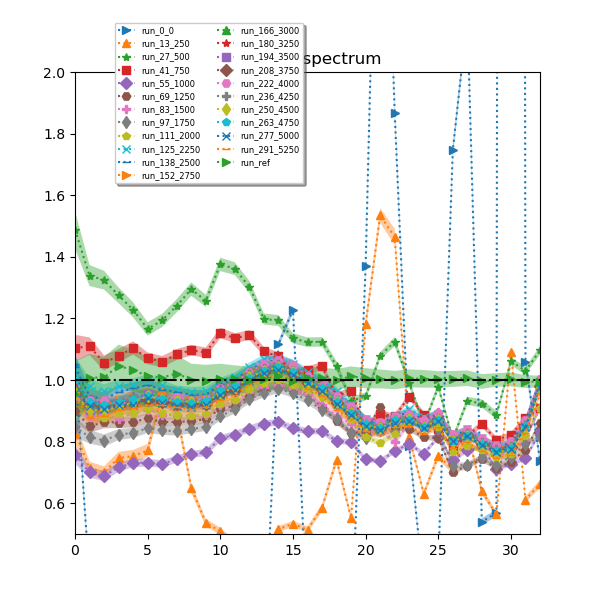

In [39]:
def f_plot_hist_spec(df,dict_val,plot_type,img_size):

    assert plot_type in ['hist','spec','spec_relative','grid'],"Invalid mode %s"%(plot_type)
    
    if plot_type in ['hist','spec','spec_relative']:     fig=plt.figure(figsize=(6,6))
    
    for (i,row),marker in zip(df.iterrows(),itertools.cycle('>^*sDHPdpx_')):
        label=row.label
        if plot_type=='hist':
            x1=row.hist_bin_centers
            y1=row.hist_val
            yerr1=row.hist_err
            x1=f_invtransform(x1,kappa)
            
            plt.errorbar(x1,y1,yerr1,marker=marker,markersize=5,linestyle='',label=label)
            
        if plot_type=='spec':
            
            y=row.spec_val
            yerr=row.spec_sdev
            x=np.arange(len(y))
            # y=x**2*y; yerr=x**2*yerr ## Plot k^2 P(y)
            
            plt.fill_between(x, y - yerr, y + yerr, alpha=0.4)
            plt.plot(x, y, marker=marker, linestyle=':',label=label)

        if plot_type=='spec_relative':
            
            y2=row.spec_val
            yerr2=row.spec_sdev
            x2=np.arange(len(y2))
            
            dict_bkg=dict_val


            ### Reference spectrum
            y1,yerr1=dict_bkg['spec_val'],dict_bkg['spec_sdev']
            y=y2/(1.0*y1)
            ## Variance is sum of variance of both variables, since they are uncorrelated
            
            # delta_r=sqrt(\delta_c2 ^ 2/ c1^2 + \delta_c1^2 * c_2^2 / c_1^4)
            yerr=(np.abs(y))*np.sqrt((yerr1/y1)**2+(yerr2/y2)**2)/np.sqrt(row.num_imgs)
            
            plt.fill_between(x2, y - yerr, y + yerr, alpha=0.4)
            plt.plot(x2, y, marker=marker, linestyle=':',label=label)
            plt.xlim(0,img_size)
            plt.legend()
            plt.title("relative spectrum")
        if plot_type=='grid':
            images=np.load(row.fname)[:,0,:,:,0]
            f_plot_grid(images[:8],cols=4,fig_size=(8,4))

            
    ### Plot input data
    dict_bkg=dict_val
    if plot_type=='hist':
        x,y,yerr=dict_bkg['hist_bin_centers'],dict_bkg['hist_val'],dict_bkg['hist_err']
        x=f_invtransform(x,kappa)
        plt.errorbar(x, y,yerr,color='k',linestyle='-',label='bkgnd')   
        plt.title('Pixel Intensity Histogram')
#         plt.xscale('symlog',linthreshx=50)
        plt.xscale('log')

    if plot_type=='spec':
        y,yerr=dict_bkg['spec_val'],dict_bkg['spec_sdev']

        x=np.arange(len(y))
        # y=x**2*y; yerr=x**2*yerr ## Plot k^2 P(y)
        plt.fill_between(x, y - yerr, y + yerr, color='k',alpha=0.8)
        plt.title('Spectrum')
        plt.xlim(0,img_size/2)


    if plot_type=='spec_relative':
        plt.axhline(y=1.0,color='k',linestyle='-.')
        plt.title("relative spectrum")
        plt.xlim(0,img_size/2)
        plt.ylim(0.5,2)    

    if plot_type in ['hist','spec']:     
        plt.yscale('log')
    plt.legend(bbox_to_anchor=(0.5, 0.75),ncol=2, fancybox=True, shadow=True,prop={'size':6})

    
    plt.show()
    
# f_plot_hist_spec(df_runs,dict_val,'hist',img_size)
# f_plot_hist_spec(df_runs,dict_val,'spec',img_size)
f_plot_hist_spec(df_runs,dict_val,'spec_relative',img_size)
# f_plot_hist_spec(df_runs,dict_val,'grid',img_size)


## Widget

In [19]:
def f_widget_compare(df,labels_list,bkgnd,plot_type):
    df_temp=df[df.label.isin(labels_list)]
    f_plot_hist_spec(df_temp,bkgnd,plot_type,img_size)

# df_runs=df_runs.sort_values(by=['chi_1'])
# df_runs=df_runs.sort_values(by=['chi_spec3'])

interact_manual(f_widget_compare,df=fixed(df_runs),
                labels_list=SelectMultiple(options=df_runs.label.values), 
                img_size=fixed(img_size),
                bkgnd=fixed(dict_val),plot_type=ToggleButtons(options=['hist','spec','spec_relative','grid']))

NameError: name 'interact_manual' is not defined

In [ ]:
col_list=['label','chi_1','chi_spec1','num_imgs','chi_2','chi_spec2','chi_spec3']
df_runs[col_list]

<IPython.core.display.Javascript object>


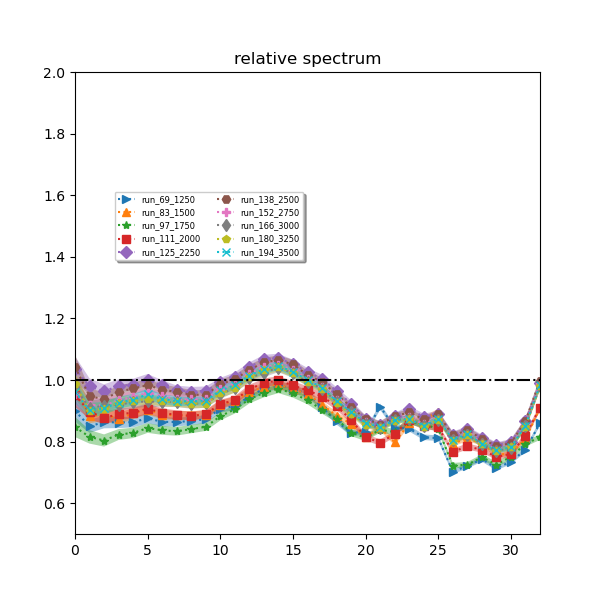

In [43]:

# label_lst=['run_114_4000']
# df=df_runs[df_runs.label.isin(label_lst)]
df=df_runs[5:15]

f_plot_hist_spec(df,dict_val,'spec_relative',img_size)
# f_plot_hist_spec(df,dict_val,'hist',img_size)
# f_plot_hist_spec(df,dict_val,'grid',img_size)
